# Ultimate Guitar Scraping

## Problems

- No consecutive IDs.
- Search engine does not show all the results
- Just 20 pages per search (~1001 results)


## Solution

Filter by different critera (decade, genre, subgenre).

This could be enough in a first approach.

Additionally, we will store the criteria for each song (it could be useful).

Search URL pattern: 

## Search URL Pattern

We look only for chords, so the base URL will be:
    
```
    https://www.ultimate-guitar.com/explore?&type[]=Chords
```

To add search criteria, the format is:

```
    https://www.ultimate-guitar.com/explore?&type[]=Chords&genres[]=4&subgenres[]=24
```

* 4 is for genre `Rock`
* 24 is for sub-genre  `Pop-rock`


## Search criteria

## Why Selenium? Isn’t Beautiful Soup enough?

Web scraping with Python often requires no more than the use of the Beautiful Soup to reach the goal. Beautiful Soup is a very powerful library that makes web scraping by traversing the DOM (document object model) easier to implement. But it does only static scraping. Static scraping ignores JavaScript. It fetches web pages from the server without the help of a browser. You get exactly what you see in “view page source”, and then you slice and dice it. If the data you are looking for is available in “view page source” only, you don’t need to go any further. But if you need data that are present in components which get rendered on clicking JavaScript links, dynamic scraping comes to the rescue. The combination of Beautiful Soup and Selenium will do the job of dynamic scraping. Selenium automates web browser interaction from python. Hence the data rendered by JavaScript links can be made available by automating the button clicks with Selenium and then can be extracted by Beautiful Soup.

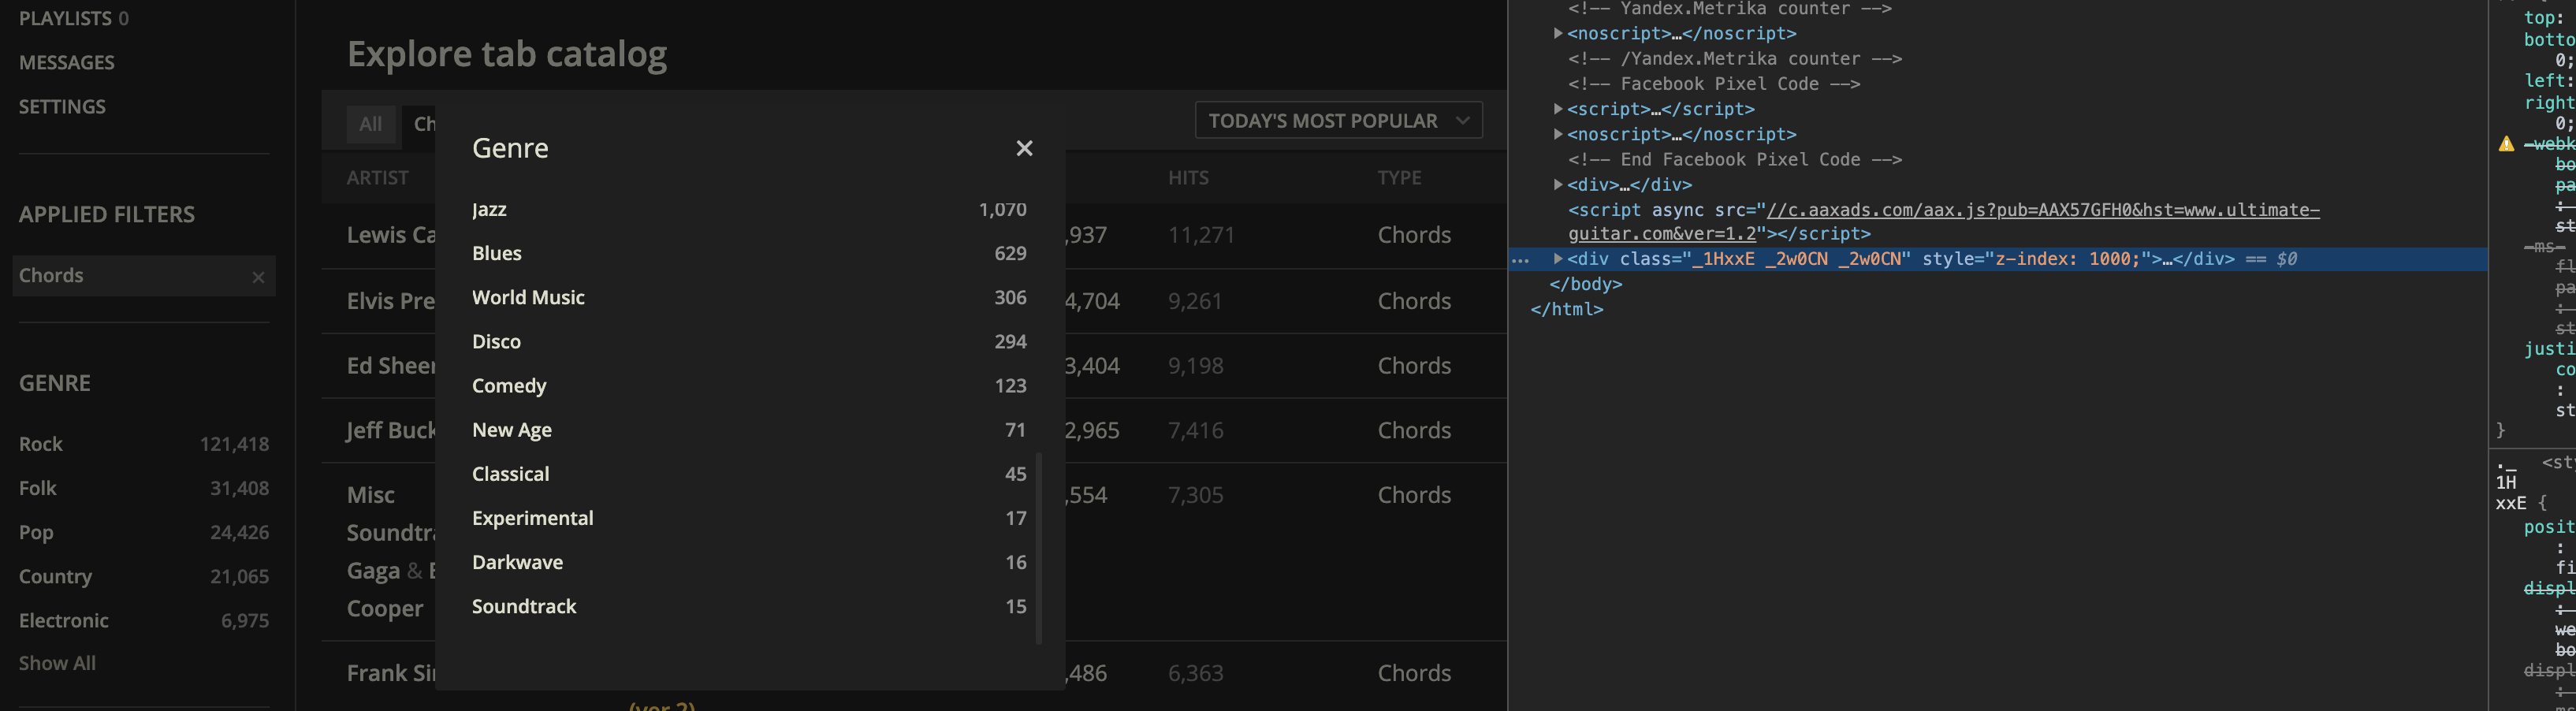

In [6]:
pip install bs4 selenium

Note: you may need to restart the kernel to use updated packages.


As requisite, chrome driver must be installed from  https://sites.google.com/a/chromium.org/chromedriver/home and copied to the same folder as this notebook (my version is copied, but it could not work on your computer). The driver must be compatible with the installed chrome version.


In `MacOS`, you must additionally allow mac-os to run non-known apps: pen System Preferences and click Security & Privacy. Change "Allow apps downloaded from" to Anywhere.



Let's create a Selenium Driver to access the page

In [7]:
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome("./chromedriver", options=options)

Now, we click of first 'Select All' button, to show a dialog with all the `genres`. 

In [8]:
driver.get("https://www.ultimate-guitar.com/explore?type[]=Chords")
show_all = driver.find_elements_by_xpath("//*[contains(text(), 'Show All')]")

genre_show_all = show_all[0];
driver.execute_script("arguments[0].click();", genre_show_all)
page_source = driver.page_source

When the button is clicked, the html of the page is modified to add a new `div` at the end of the page showing the dialog. Now, we can use `BeautifulSoup` to parse the html and look for the last `div`.

In [9]:
def print_html(htmlElement):
    print(htmlElement.prettify())

In [10]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page_source, 'lxml')

In [11]:
print_html(soup)

<html lang="en">
 <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# article: http://ogp.me/ns/article#">
  <script async="" src="https://www.ultimate-guitar.com/static/vendor/centry/raven.min.js" type="text/javascript">
  </script>
  <script async="" src="https://www.ultimate-guitar.com/static/vendor/metrica/watch_ver1572714417.js" type="text/javascript">
  </script>
  <script async="" src="//www.ultimate-guitar.com/static/vendor/ga/analytics_ver1572714417.js">
  </script>
  <script async="" src="//c.amazon-adsystem.com/aax2/apstag.js">
  </script>
  <script async="" src="https://www.ultimate-guitar.com/static/public/build/prebid/prebid_ver1572714417.js" type="text/javascript">
  </script>
  <script async="" src="//js-sec.indexww.com/ht/p/184163-80734171996343.js" type="text/javascript">
  </script>
  <script>
   !function(n,e){var t,o,i,c=[],f={passive:!0,capture:!0},r=new Date,a="pointerup",u="pointercancel";function p(n,c){t||(t=c,o=n,i=new Date,w(e),s())}function s(){o>=

In [12]:
results = soup.findAll("div")
last_div = results[len(results)-1]

Let's explore the div:

In [13]:
print(last_div.prettify())

<div class="Ds8yG">
 <button class="BjUfA">
  Show our partners
 </button>
</div>


We have several `<a>` tags. 
Inside the `value` attribute, we have the code of the genre:

This allow that every class annotated with `@auto_str` automatically has a readable `__str__` method

In [14]:
def auto_str(cls):
    def __str__(self):
        return f"{type(self).__name__}={', '.join('%s=%s' % item for item in vars(self).items())}"

    cls.__str__ = __str__
    return cls

The class `filter_item` extract the information for a specific filter item (eg. `Rock`) by reading the `a` element passed as parameter

In [176]:
@auto_str
class filter_item:
    def __init__(self, a_element):
        first_span = a_element.findAll('span')[0]
        href = a_element['href']
        
        self.code = a_element['value']
        self.name = first_span.text
        self.filter_pattern = href[href.index('&&'):]
        
    def to_dictionary(self):
        return {"code": self.code, "name": self.name, "pattern": self.filter_pattern}
    

In [177]:
all_filter_items = last_div.find_all('a')

In [178]:
genres = [(filter_item(a)) for a in all_filter_items]

In [179]:
def print_list(list):
    return [str(x) for x in list]

In [180]:
print_list(genres)

[]

Let's wrap up all this code into a classes

In [181]:
from enum import IntEnum

class FilterType(IntEnum):
    GENRE = 0
    STYLE = 1
    DECADE = 2

In [182]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time

class SingleFilterExtractor:
    PAGE_URL = "https://www.ultimate-guitar.com/explore?type[]=Chords";
    
    def __init__(self):
        pass
    
    def get_all_filter_items(self,filter_type):
        driver = self.create_chrome_driver();
        driver.get(self.PAGE_URL)
        
        self.click_on_accept_cookies(driver)
        
        time.sleep(5)
        self.click_on_filter(driver,filter_type);
        time.sleep(5)
        soup = BeautifulSoup(driver.page_source, 'lxml')

        last_div = self.get_last_div(soup, filter_type)  

        all_links_inside_div = last_div.find_all('a')
        
        filter_items = [(filter_item(a)) for a in all_links_inside_div]
        
        return filter_items
        
    def get_last_div(self,soup, filter_type):
        results = soup.findAll("div")
        
        if filter_type == 1:
            last_div = results[len(results)-2]      
        else:
            last_div = results[len(results)-1]   
        
        return last_div
    
    def click_on_accept_cookies(self, driver):
        button = driver.find_element_by_xpath('//button[contains(text(), "thanks")]')

        button.click()
    
    def click_on_filter(self,driver, filter_type):    
        show_all_links = driver.find_elements_by_xpath("//*[contains(text(), 'Show All')]")

        single_filter_link = show_all_links[filter_type];
    
        driver.execute_script("arguments[0].click();", single_filter_link)   
    
    def create_chrome_driver(self):
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--incognito')
        options.add_argument('--headless')
        
        driver = webdriver.Chrome("./chromedriver", options=options)
        return driver
        
    

TODO:

* Extract print_list, print_html y auto_str to string_extensions o algo así.
* Hacerlo para el resto de filtros. 

In [183]:
extractor = SingleFilterExtractor()

In [184]:
genres = extractor.get_all_filter_items(FilterType.GENRE)
print_list(genres)

['filter_item=code=4, name=Rock, filter_pattern=&&genres[]=4',
 'filter_item=code=666, name=Folk, filter_pattern=&&genres[]=666',
 'filter_item=code=14, name=Pop, filter_pattern=&&genres[]=14',
 'filter_item=code=49, name=Country, filter_pattern=&&genres[]=49',
 'filter_item=code=16, name=Electronic, filter_pattern=&&genres[]=16',
 'filter_item=code=70, name=Rhythm And Blues, filter_pattern=&&genres[]=70',
 'filter_item=code=8, name=Metal, filter_pattern=&&genres[]=8',
 'filter_item=code=434, name=Contemporary R&b, filter_pattern=&&genres[]=434',
 'filter_item=code=1016, name=Religious Music, filter_pattern=&&genres[]=1016',
 'filter_item=code=45, name=Hip Hop, filter_pattern=&&genres[]=45',
 'filter_item=code=19, name=Reggae, filter_pattern=&&genres[]=19',
 'filter_item=code=84, name=Jazz, filter_pattern=&&genres[]=84',
 'filter_item=code=99, name=Blues, filter_pattern=&&genres[]=99',
 'filter_item=code=195, name=World Music, filter_pattern=&&genres[]=195',
 'filter_item=code=85, name

In [185]:
styles = extractor.get_all_filter_items(FilterType.STYLE)
print_list(styles)

['filter_item=code=24, name=Pop Rock, filter_pattern=&&subgenres[]=24',
 'filter_item=code=665, name=Singer-songwriter, filter_pattern=&&subgenres[]=665',
 'filter_item=code=3, name=Alternative Rock, filter_pattern=&&subgenres[]=3',
 'filter_item=code=9, name=Indie Rock, filter_pattern=&&subgenres[]=9',
 'filter_item=code=46, name=Indie Pop, filter_pattern=&&subgenres[]=46',
 'filter_item=code=1, name=Pop Punk, filter_pattern=&&subgenres[]=1',
 'filter_item=code=7, name=Hard Rock, filter_pattern=&&subgenres[]=7',
 'filter_item=code=813, name=Contemporary Folk, filter_pattern=&&subgenres[]=813',
 'filter_item=code=94, name=Folk Rock, filter_pattern=&&subgenres[]=94',
 'filter_item=code=1093, name=Folk Pop, filter_pattern=&&subgenres[]=1093',
 'filter_item=code=1087, name=Contemporary Country, filter_pattern=&&subgenres[]=1087',
 'filter_item=code=197, name=Country Pop, filter_pattern=&&subgenres[]=197',
 'filter_item=code=104, name=Electropop, filter_pattern=&&subgenres[]=104',
 'filter

In [186]:
decades = extractor.get_all_filter_items(FilterType.DECADE)
print_list(decades)

['filter_item=code=2010, name=2010s, filter_pattern=&&decade[]=2010',
 'filter_item=code=2000, name=2000s, filter_pattern=&&decade[]=2000',
 'filter_item=code=1990, name=1990s, filter_pattern=&&decade[]=1990',
 'filter_item=code=1980, name=1980s, filter_pattern=&&decade[]=1980',
 'filter_item=code=1970, name=1970s, filter_pattern=&&decade[]=1970',
 'filter_item=code=1960, name=1960s, filter_pattern=&&decade[]=1960',
 'filter_item=code=1950, name=1950s, filter_pattern=&&decade[]=1950']

### Guardamos los datos 

In [189]:
! rm data.h5

In [190]:
import h5py
hf = h5py.File('data.h5', 'w')

In [194]:
hf.create_dataset('genres', data=map(lambda item: item.to_dictionary(),genres))


TypeError: Object dtype dtype('O') has no native HDF5 equivalent